# Question 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
#endmember order: Rain, Soil water, Groundwater
d18O_e = np.array([-4.0, -8.0, -11.0], dtype=float)   # ‰
Si_e   = np.array([ 1.0,  8.0,  20.0], dtype=float)   # mg/L

#storm data
data = [
    (0,  2.0, -11.0, 18.0),
    (2,  4.5,  -9.5, 15.0),
    (4,  9.0,  -8.5, 12.0),
    (6, 12.0,  -7.8, 10.0),
    (10, 7.0,  -8.8, 13.0),
    (16, 4.0,  -9.8, 16.0),
    (24, 2.5, -10.5, 17.0),
]
df = pd.DataFrame(data, columns=["time_hr", "Q_m3s", "d18O_obs", "Si_obs"])

def solve_fractions_nonnegative(d18O_obs, Si_obs):
    """
    non-negative 3-endmember (Rain, Soil, GW) solver with sum-to-1 constraint.
    If the exact solution yields negatives, it finds the closest point on the
    mixing triangle (edges/vertices) in (d18O, Si) space.

    returns fractions [f_rain, f_soil, f_gw].
    """
    X = d18O_e
    Y = Si_e
    x_obs = float(d18O_obs)
    y_obs = float(Si_obs)

    candidates = []

    #exact unconstrained solve (three equation problem)
    A = np.array([
        [1.0, 1.0, 1.0],
        [X[0], X[1], X[2]],
        [Y[0], Y[1], Y[2]],
    ], dtype=float)
    b = np.array([1.0, x_obs, y_obs], dtype=float)

    try:
        f_unc = np.linalg.solve(A, b)
        if np.all(f_unc >= -1e-12):
            f_unc = np.clip(f_unc, 0.0, None)
            f_unc = f_unc / f_unc.sum()
            x_mix = f_unc @ X
            y_mix = f_unc @ Y
            obj = (x_mix - x_obs)**2 + (y_mix - y_obs)**2
            candidates.append((obj, f_unc))
    except np.linalg.LinAlgError:
        pass

    #edge projections (set one fraction = 0)
    #for edge i-j: f_i=t, f_j=1-t, f_k=0, t in [0,1]
    edges = [(0, 1, 2), (0, 2, 1), (1, 2, 0)]  # (i, j, k)
    for i, j, k in edges:
        Xi, Xj = X[i], X[j]
        Yi, Yj = Y[i], Y[j]

        a1 = Xi - Xj
        b1 = Xj - x_obs
        a2 = Yi - Yj
        b2 = Yj - y_obs

        denom = a1*a1 + a2*a2
        t_star = 0.0 if denom == 0 else -(a1*b1 + a2*b2) / denom
        t = float(np.clip(t_star, 0.0, 1.0))

        f = np.zeros(3, dtype=float)
        f[i] = t
        f[j] = 1.0 - t
        f[k] = 0.0

        x_mix = f @ X
        y_mix = f @ Y
        obj = (x_mix - x_obs)**2 + (y_mix - y_obs)**2
        candidates.append((obj, f))

    #Vertices
    for k in range(3):
        f = np.zeros(3, dtype=float)
        f[k] = 1.0
        x_mix = f @ X
        y_mix = f @ Y
        obj = (x_mix - x_obs)**2 + (y_mix - y_obs)**2
        candidates.append((obj, f))

    candidates.sort(key=lambda z: z[0])
    return candidates[0][1]

#solve all times
F = np.vstack([solve_fractions_nonnegative(r.d18O_obs, r.Si_obs)
               for r in df.itertuples(index=False)])

df["f_rain"] = F[:, 0]
df["f_soil"] = F[:, 1]
df["f_gw"]   = F[:, 2]

# Print just the numbers table
print(df[["time_hr", "f_rain", "f_soil", "f_gw"]].to_string(
    index=False,
    float_format=lambda x: f"{x:0.3f}"
))

# If you only want the event-water (rain) fraction vs time:
print("\nEvent water fraction (rain) vs time:")
for t, fr in zip(df["time_hr"].values, df["f_rain"].values):
    print(f"{t:>2} hr: {fr:0.3f}")


 time_hr  f_rain  f_soil  f_gw
       0   0.000   0.157 0.843
       2   0.111   0.241 0.648
       4   0.222   0.315 0.463
       6   0.311   0.341 0.348
      10   0.200   0.267 0.533
      16   0.089   0.193 0.719
      24   0.000   0.245 0.755

Event water fraction (rain) vs time:
 0 hr: 0.000
 2 hr: 0.111
 4 hr: 0.222
 6 hr: 0.311
10 hr: 0.200
16 hr: 0.089
24 hr: 0.000



Fractions:
 time_hr  f_rain  f_soil  f_gw
       0  -0.222   0.519 0.704
       2   0.111   0.241 0.648
       4   0.222   0.315 0.463
       6   0.311   0.341 0.348
      10   0.200   0.267 0.533
      16   0.089   0.193 0.719
      24  -0.111   0.426 0.685


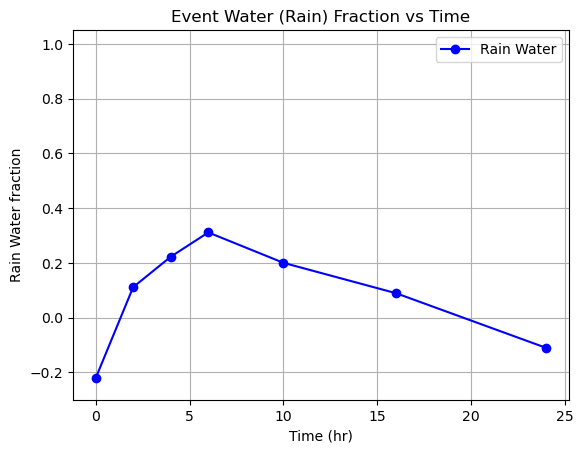

In [3]:
endmembers = {
    "Rain":        {"d18O": -4.0,  "Si":  1.0},
    "Soil water":  {"d18O": -8.0,  "Si":  8.0},
    "Groundwater": {"d18O": -11.0, "Si": 20.0},
}

#put endmembers into arrays in a fixed order
sources = ["Rain", "Soil water", "Groundwater"]
d18O_e = np.array([endmembers[s]["d18O"] for s in sources], dtype=float)
Si_e   = np.array([endmembers[s]["Si"]   for s in sources], dtype=float)

#matrix A for: [sum fractions, d18O mix, Si mix] = [1, d18O_obs, Si_obs]
A = np.array([
    [1.0,   1.0,   1.0],
    d18O_e,
    Si_e
], dtype=float)


#Stormwater observations
data = [
    # time_hr, Q(m3/s), d18O,  Si
    (0,   2.0,  -11.0, 18.0),
    (2,   4.5,   -9.5, 15.0),
    (4,   9.0,   -8.5, 12.0),
    (6,  12.0,   -7.8, 10.0),  
    (10,  7.0,   -8.8, 13.0),
    (16,  4.0,   -9.8, 16.0),
    (24,  2.5,  -10.5, 17.0),
]
df = pd.DataFrame(data, columns=["time_hr", "Q_m3s", "d18O_obs", "Si_obs"])

#solve endmember fractions at each time
def solve_fractions(d18O_obs: float, Si_obs: float) -> np.ndarray:
    b = np.array([1.0, d18O_obs, Si_obs], dtype=float)
    f = np.linalg.solve(A, b)  # [f_rain, f_soil, f_gw]
    return f

fractions = np.vstack([solve_fractions(r.d18O_obs, r.Si_obs) for r in df.itertuples(index=False)])
df["f_rain"] = fractions[:, 0]
df["f_soil"] = fractions[:, 1]
df["f_gw"]   = fractions[:, 2]


#output table
print("\nFractions:")
print(df[["time_hr", "f_rain", "f_soil", "f_gw"]].to_string(index=False, float_format=lambda x: f"{x:0.3f}"))


# ----------------------------
# Plot: event water fraction vs time
# (event water = rain; use raw or clipped depending on what you want to show)
# -----------------------------
plt.figure()
plt.plot(df["time_hr"], df["f_rain"], marker="o", color = 'b', label="Rain Water")
plt.xlabel("Time (hr)")
plt.ylabel("Rain Water fraction")
plt.title("Event Water (Rain) Fraction vs Time")
plt.ylim(-0.3, 1.05)
plt.grid(True)
plt.legend()
plt.show()


   time_hr  d18O_obs  Si_obs          Rain  Soil water  Groundwater
0        0     -11.0    18.0  3.606599e-16    0.156863     0.843137
1        2      -9.5    15.0  1.111111e-01    0.240741     0.648148
2        4      -8.5    12.0  2.222222e-01    0.314815     0.462963
3        6      -7.8    10.0  3.111109e-01    0.340741     0.348148
4       10      -8.8    13.0  1.999999e-01    0.266667     0.533333
5       16      -9.8    16.0  8.888862e-02    0.192593     0.718519
6       24     -10.5    17.0  2.022037e-17    0.245098     0.754902


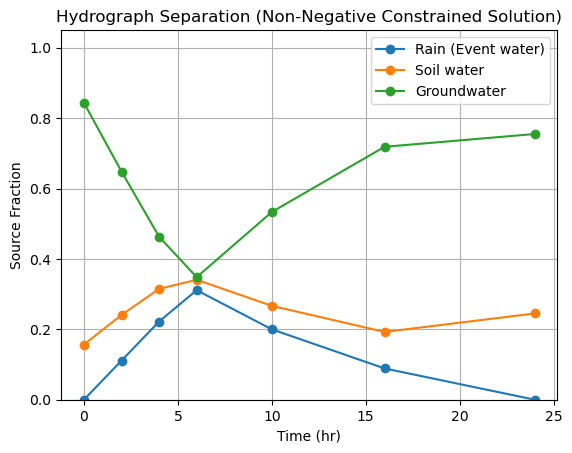

In [4]:
#storm data @ time
data = [
    (0,  -11.0, 18.0),
    (2,   -9.5, 15.0),
    (4,   -8.5, 12.0),
    (6,   -7.8, 10.0),
    (10,  -8.8, 13.0),
    (16,  -9.8, 16.0),
    (24, -10.5, 17.0),
]

df = pd.DataFrame(data, columns=["time_hr", "d18O_obs", "Si_obs"])


# solve the constraints
def solve_constrained(d18O_obs, Si_obs):
    
    #objective function (least squares error)
    def objective(f):
        d18O_mix = np.dot(f, d18O_e)
        Si_mix   = np.dot(f, Si_e)
        return (d18O_mix - d18O_obs)**2 + (Si_mix - Si_obs)**2
    
    cons = ({
        'type': 'eq',
        'fun': lambda f: np.sum(f) - 1
    })
    
    # Bounds: no negative fractions
    bounds = [(0,1), (0,1), (0,1)]
    
    # Initial guess
    f0 = np.array([0.3, 0.3, 0.4])
    
    result = minimize(objective, f0, bounds=bounds, constraints=cons)
    
    return result.x

# Solve for each time
fractions = np.vstack([
    solve_constrained(row.d18O_obs, row.Si_obs)
    for row in df.itertuples()
])

df["Rain"] = fractions[:,0]
df["Soil water"] = fractions[:,1]
df["Groundwater"] = fractions[:,2]

print(df)
plt.figure()

plt.plot(df["time_hr"], df["Rain"], marker='o', label="Rain (Event water)")
plt.plot(df["time_hr"], df["Soil water"], marker='o', label="Soil water")
plt.plot(df["time_hr"], df["Groundwater"], marker='o', label="Groundwater")

plt.xlabel("Time (hr)")
plt.ylabel("Source Fraction")
plt.title("Hydrograph Separation (Non-Negative Constrained Solution)")
plt.ylim(0,1.05)
plt.grid(True)
plt.legend()
plt.show()



## Question 5


In [5]:
#'d' equals dirac notation

#create endmembers using given table values
endmembers = {
    "Throughfall": {"D": -53.0, "d18O": -8.30, "Cl": 6.98, "Na": 0.39},
    "Soil water":  {"dD": -38.5, "d18O": -6.35, "Cl": 10.1, "Na": 5.81},
    "Groundwater": {"dD": -47.0, "d18O": -7.97, "Cl": 35.6, "Na": 30.3},
}

stream = {"dD": -49.0, "d18O": -7.90, "Cl": 21.2, "Na": 17.6}

#label the sources
sources = ["Throughfall", "Soil water", "Groundwater"]

### Part 1: Fractions of Endmembers (δD and Cl-1)

In [6]:
#build a matrix for a linear system to solve endmember fractions
A = np.array([
    [1, 1, 1],     
    Cl,
    dD
], dtype=float)

b = np.array([
    1,
    Cl_stream,
    dD_stream
], dtype=float)

#solve the system
fractions = np.linalg.solve(A, b)
labels = ["Throughfall", "Soil water", "Groundwater"]

print("Fractions at Streamflow Peak:")
for label, value in zip(labels, fractions):
    print(f"{label}: {value*100:.1f}%")


NameError: name 'Cl' is not defined

### Part 2: Plot Mixing Diagrams

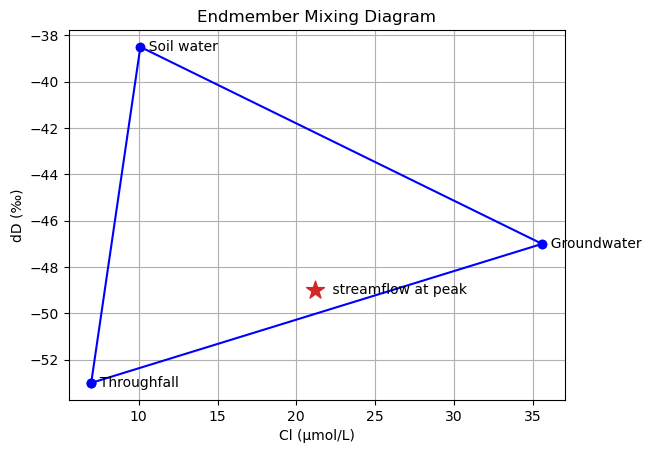

In [ ]:
endmembers = {
    "Throughfall": {"dD": -53.0, "d18O": -8.30, "Cl": 6.98, "Na": 0.39},
    "Soil water":  {"dD": -38.5, "d18O": -6.35, "Cl": 10.1, "Na": 5.81},
    "Groundwater": {"dD": -47.0, "d18O": -7.97, "Cl": 35.6, "Na": 30.3},
}

# Iterate through the event to solve for the fractino of endmembers / tracers
# Enforces: f>=0 and sum(f)=1 (recommended)
def solve_fractions_nonneg(tracer_x, tracer_y):
    try:
        from scipy.optimize import minimize
    except ImportError:
        minimize = None

    X = np.array([endmembers[s][tracer_x] for s in sources], dtype=float)
    Y = np.array([endmembers[s][tracer_y] for s in sources], dtype=float)
    x_obs = float(stream[tracer_x])
    y_obs = float(stream[tracer_y])

    if minimize is None:
        #fallback: unconstrained solve + clip + renormalize
        A = np.array([[1, 1, 1],
                      [X[0], X[1], X[2]],
                      [Y[0], Y[1], Y[2]]], dtype=float)
        b = np.array([1.0, x_obs, y_obs], dtype=float)
        f = np.linalg.solve(A, b)
        f = np.clip(f, 0.0, None)
        if f.sum() > 0:
            f = f / f.sum()
        return f

    #constrained least squares: minimize tracer residuals (removes negative numbers)
    def objective(f):
        x_mix = np.dot(f, X)
        y_mix = np.dot(f, Y)
        return (x_mix - x_obs) ** 2 + (y_mix - y_obs) ** 2

    cons = ({'type': 'eq', 'fun': lambda f: np.sum(f) - 1.0},)
    bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
    f0 = np.array([0.33, 0.33, 0.34])
    res = minimize(objective, f0, bounds=bounds, constraints=cons)

    if not res.success:
        # fallback
        f = np.clip(res.x, 0.0, None)
        if f.sum() > 0:
            f = f / f.sum()
        return f

    return res.x

#plotting support for this problem
def plot_mixing_diagram(tracer_x, tracer_y, title=None):
    # Collect endmember points
    xs = np.array([endmembers[s][tracer_x] for s in sources], dtype=float)
    ys = np.array([endmembers[s][tracer_y] for s in sources], dtype=float)

    #stream point
    x_stream = stream[tracer_x]
    y_stream = stream[tracer_y]

    plt.figure()
    #triangle diagrame edges
    order = [0, 1, 2, 0]
    plt.plot(xs[order], ys[order], marker="o", color= 'b')

    #label endmembers
    for s in sources:
        plt.scatter(endmembers[s][tracer_x], endmembers[s][tracer_y])
        plt.text(endmembers[s][tracer_x], endmembers[s][tracer_y], f"  {s}", va="center")

    #stream point
    plt.scatter([x_stream], [y_stream], marker="*", s=180)
    plt.text(x_stream, y_stream, "    streamflow at peak", va="center")

    plt.xlabel(f"{tracer_x} ({'μmol/L' if tracer_x in ['Cl','Na'] else '‰'})")
    plt.ylabel(f"{tracer_y} ({'μmol/L' if tracer_y in ['Cl','Na'] else '‰'})")
    plt.title(title if title else f"Mixing diagram: {tracer_y} vs {tracer_x}")
    plt.grid(True)
    plt.show()

#x = Cl-, y = δD
plot_mixing_diagram("Cl", "dD", title="Endmember Mixing Diagram")

### Part 3: Using δ¹⁸O and Cl-1 Endmembers as Tracers

In [ ]:
#endmembers: throughfall, soil, groundwater
Cl = np.array([6.98, 10.1, 35.6])            
d18O = np.array([-8.30, -6.35, -7.97])      

#stream at peak
Cl_stream = 21.2
d18O_stream = -7.90

#create the matrix
A = np.array([
    [1, 1, 1],       
    Cl,
    d18O
], dtype=float)

b = np.array([
    1.0,
    Cl_stream,
    d18O_stream
], dtype=float)

#linear solution
fractions = np.linalg.solve(A, b)
labels = ["Throughfall", "Soil water", "Groundwater"]

print("Fractions at Streamflow Peak Using (δ18O + Cl⁻):")
for label, value in zip(labels, fractions):
    print(f"{label}: {value*100:.1f}%")


Fractions at Streamflow Peak Using (δ18O + Cl⁻):
Throughfall: 39.3%
Soil water: 12.3%
Groundwater: 48.3%


### Part 4: Using δD and Na+ as Tracers

In [ ]:
#endmembers: throughfall, soil water, groundwater
Na = np.array([0.39, 5.81, 30.3])       
dD = np.array([-53.0, -38.5, -47.0])    

# Stream at peak
Na_stream = 17.6
dD_stream = -49.0

# ----------------------------
# Build linear system
# ----------------------------
A = np.array([
    [1, 1, 1],     # fractions sum to 1
    Na,
    dD
], dtype=float)

b = np.array([
    1.0,
    Na_stream,
    dD_stream
], dtype=float)

#solve linearly
fractions = np.linalg.solve(A, b)
labels = ["Throughfall", "Soil water", "Groundwater"]

print("Fractions at peak flow (δD + Na⁺):")
for label, value in zip(labels, fractions):
    print(f"{label}: {value*100:.1f}%")


Fractions at peak flow (δD + Na⁺):
Throughfall: 39.1%
Soil water: 4.1%
Groundwater: 56.8%
